## Forecasting El Nino-Southern Oscillation (ENSO)
##### Univariate Multistep Forecasting

ENSO is one of the most important climate phenomena on Earth due to its ability to change global atmospheric circulation, which influences temperature and precipitation across the globe.
It has three states/phases:
- El Nino / warm phase: the unusual warm ocean temperatures in the eastern Pacific
- La Nina / cool phase: the unusual cool ocean temperatures in the eastern Pacific
- Neutral: neither El Nino nor La Nina


### Problem
ENSO prediction is one of the most challenging tasks in climatology. It is one of the main drivers of the interannual climate variability of Earth and can cause a wide range of climate anomalies. The impacts include natural disasters (floods, droughts), low & high agriculture yields, price fluctuation, energy demand, availability of water resources, animal movement, and many more. 

### Primary Indicators
The primary indicators for ENSO are ONI and MEI.v2. ONI, the preferred indicator by NOAA,
is the 3-month average SST anomaly in the Nino 3.4 region. To be considered an El Nino/La Nina event, the SST anomalies in the Nino 3.4 region must meet the following criteria and remain at or above/below these levels for a minimum of five consecutive months.
- El Nino → anomalies at or above +0.5°C
- La Nina → anomalies at or below -0.5°C 
- Neutral → anomalies between -0.5°C and +0.5°C

The threshold is further divided into:
- Weak → 0.5 to 0.9 °C SST anomaly
- Moderate → 1.0 to 1.4
- Strong → 1.5 to 1.9 
- Very Strong → ≥ 2.0 

### Forecasting Type
Univariate multistep time series forecasting

### Approach/Model
Deep Learning (LSTM Recurrent Neural Networks)

### Evaluation Metrics
- Mean Absolute Error (MAE)
- Mean Absolute Percentage Error (MAPE)
- Root Mean Square Error (RMSE)

In [1]:
# libraries

import matplotlib
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import plotly.express as px 
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Conv1D, MaxPooling1D, Flatten, SimpleRNN, LSTM, TimeDistributed
from tensorflow.keras.metrics import RootMeanSquaredError

### Data
Training, Validation & Testing: [El Nino-Southern Oscillation (ENSO) Data]( https://www.kaggle.com/datasets/shabanamir/enso-data)

### Data Understanding

In [2]:
# load data
df_enso = pd.read_csv('../input/enso-data/ENSO.csv', parse_dates=[0])
df_enso.head()

,Date,Year,Month,Global Temperature Anomalies,Nino 1+2 SST,Nino 1+2 SST Anomalies,Nino 3 SST,Nino 3 SST Anomalies,Nino 3.4 SST,Nino 3.4 SST Anomalies,...,TNI,PNA,OLR,SOI,Season (2-Month),MEI.v2,Season (3-Month),ONI,Season (12-Month),ENSO Phase-Intensity
0,1950-01-01,1950,JAN,-0.20,NaN,NaN,NaN,NaN,NaN,NaN,...,0.624,-3.65,NaN,NaN,DJ,NaN,DJF,-1.5,1950-1951,ML
1,1950-02-01,1950,FEB,-0.26,NaN,NaN,NaN,NaN,NaN,NaN,...,0.445,-1.69,NaN,NaN,JF,NaN,JFM,-1.3,1950-1951,ML
2,1950-03-01,1950,MAR,-0.08,NaN,NaN,NaN,NaN,NaN,NaN,...,0.382,-0.06,NaN,NaN,FM,NaN,FMA,-1.2,1950-1951,ML
3,1950-04-01,1950,APR,-0.16,NaN,NaN,NaN,NaN,NaN,NaN,...,0.311,-0.23,NaN,NaN,MA,NaN,MAM,-1.2,1950-1951,ML
4,1950-05-01,1950,MAY,-0.02,NaN,NaN,NaN,NaN,NaN,NaN,...,0.124,-0.40,NaN,NaN,AM,NaN,AMJ,-1.1,1950-1951,ML


In [3]:
# data information (columns, rows, data tyype, null values etc) 
df_enso.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 882 entries, 0 to 881
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Date                          882 non-null    datetime64[ns]
 1   Year                          882 non-null    int64         
 2   Month                         882 non-null    object        
 3   Global Temperature Anomalies  882 non-null    float64       
 4   Nino 1+2 SST                  498 non-null    float64       
 5   Nino 1+2 SST Anomalies        498 non-null    float64       
 6   Nino 3 SST                    498 non-null    float64       
 7   Nino 3 SST Anomalies          498 non-null    float64       
 8   Nino 3.4 SST                  498 non-null    float64       
 9   Nino 3.4 SST Anomalies        498 non-null    float64       
 10  Nino 4 SST                    498 non-null    float64       
 11  Nino 4 SST Anomalies          49

In [4]:
# statistics summary
df_enso.describe()

,Year,Global Temperature Anomalies,Nino 1+2 SST,Nino 1+2 SST Anomalies,Nino 3 SST,Nino 3 SST Anomalies,Nino 3.4 SST,Nino 3.4 SST Anomalies,Nino 4 SST,Nino 4 SST Anomalies,TNI,PNA,OLR,SOI,MEI.v2,ONI
count,882.000000,882.000000,498.000000,498.000000,498.000000,498.000000,498.000000,498.000000,498.000000,498.000000,875.000000,882.000000,574.0000,870.000000,534.000000,882.000000
mean,1986.251701,0.337971,23.250542,-0.049859,25.967731,-0.065743,27.016325,-0.079859,28.451727,-0.100904,-0.418517,-0.109002,0.0500,0.154138,-0.067228,-0.003175
std,21.230643,0.345478,2.328832,1.046806,1.233975,0.853805,0.945222,0.829843,0.679232,0.634455,1.361371,1.034818,0.9789,0.940521,0.987631,0.832301
min,1950.000000,-0.370000,19.060000,-1.900000,23.380000,-2.160000,24.560000,-2.220000,26.360000,-1.870000,-3.376000,-3.650000,-2.8000,-3.600000,-2.500000,-2.000000
25%,1968.000000,0.060000,21.220000,-0.740000,24.985000,-0.650000,26.340000,-0.670000,28.000000,-0.570000,-1.458500,-0.787500,-0.6000,-0.400000,-0.800000,-0.600000
50%,1986.000000,0.300000,23.140000,-0.240000,25.935000,-0.170000,27.060000,-0.110000,28.560000,-0.020000,-0.497000,-0.080000,0.1000,0.200000,-0.100000,-0.100000
75%,2005.000000,0.610000,25.230000,0.440000,26.902500,0.417500,27.690000,0.440000,28.977500,0.370000,0.384500,0.600000,0.7000,0.800000,0.500000,0.500000
max,2023.000000,1.340000,28.510000,4.030000,28.810000,3.070000,29.540000,2.720000,30.220000,1.550000,4.227000,2.870000,2.3000,2.900000,2.700000,2.600000


In [5]:
# missing values
df_enso.isna().sum(axis=0)

Date                              0
Year                              0
Month                             0
Global Temperature Anomalies      0
Nino 1+2 SST                    384
Nino 1+2 SST Anomalies          384
Nino 3 SST                      384
Nino 3 SST Anomalies            384
Nino 3.4 SST                    384
Nino 3.4 SST Anomalies          384
Nino 4 SST                      384
Nino 4 SST Anomalies            384
TNI                               7
PNA                               0
OLR                             308
SOI                              12
Season (2-Month)                  0
MEI.v2                          348
Season (3-Month)                  0
ONI                               0
Season (12-Month)                 0
ENSO Phase-Intensity              6
dtype: int64

In [6]:
# set index
df_enso.set_index('Date', inplace = True)
df_enso.head(5)

,Year,Month,Global Temperature Anomalies,Nino 1+2 SST,Nino 1+2 SST Anomalies,Nino 3 SST,Nino 3 SST Anomalies,Nino 3.4 SST,Nino 3.4 SST Anomalies,Nino 4 SST,...,TNI,PNA,OLR,SOI,Season (2-Month),MEI.v2,Season (3-Month),ONI,Season (12-Month),ENSO Phase-Intensity
Date,,,,,,,,,,,,,,,,,,,,,
1950-01-01,1950,JAN,-0.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.624,-3.65,NaN,NaN,DJ,NaN,DJF,-1.5,1950-1951,ML
1950-02-01,1950,FEB,-0.26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.445,-1.69,NaN,NaN,JF,NaN,JFM,-1.3,1950-1951,ML
1950-03-01,1950,MAR,-0.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.382,-0.06,NaN,NaN,FM,NaN,FMA,-1.2,1950-1951,ML
1950-04-01,1950,APR,-0.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.311,-0.23,NaN,NaN,MA,NaN,MAM,-1.2,1950-1951,ML
1950-05-01,1950,MAY,-0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.124,-0.40,NaN,NaN,AM,NaN,AMJ,-1.1,1950-1951,ML


### Data Visualization

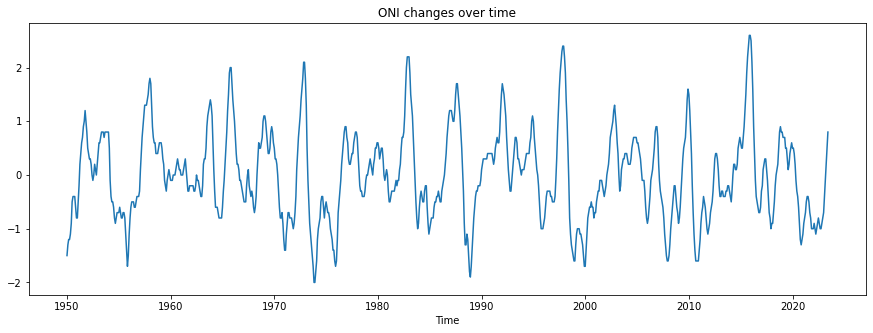

In [7]:
# ONI time series
plt.figure(figsize=(15,5))
plt.plot(df_enso.ONI)
plt.title('ONI changes over time')
plt.xlabel('Time')
plt.show()

In [8]:
# ONI interactive time series
plot = px.line(data_frame=df_enso, y='ONI', labels={'Date':'Time'},
               title='ONI changes over time')
plot.show()

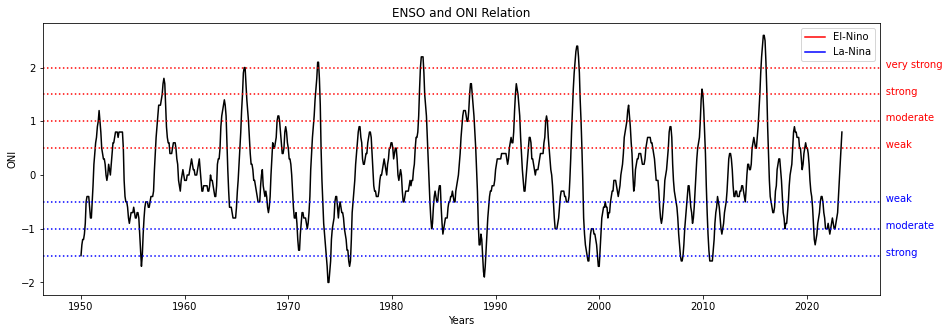

In [9]:
# ONI and ENSO relation

plt.figure(figsize=(15, 5))

# convert dates to numbers to get x-axis range
x = matplotlib.dates.date2num(df_enso.index)

# plot Year and ONI
plt.plot(df_enso.ONI, color='black')
plt.xlabel('Years')
plt.ylabel('ONI')
plt.title('ENSO and ONI Relation')

# add horizontal lines and labels to define ENSO phase and intensity

plt.axhline(y=2, color='r', linestyle=':')
plt.text(x=x[-1], y=2, color='red', s='              very strong')

plt.axhline(y=1.5, color='r', linestyle=':')
plt.text(x=x[-1], y=1.5, color='red', s='              strong')

plt.axhline(y=1, color='r', linestyle=':')
plt.text(x[-1], 1, color='r', s='              moderate')

plt.axhline(y=0.5, color='r', linestyle=':')
plt.text(x[-1], 0.5, color='r', s='              weak')

plt.axhline(y=-0.5, color='b', linestyle=':')
plt.text(x[-1], -0.5, color='b', s='              weak')

plt.axhline(y=-1, color='b', linestyle=':')
plt.text(x[-1], -1, color='b', s='              moderate')

plt.axhline(y=-1.5, color='b', linestyle=':')
plt.text(x[-1], -1.5, color='b', s='              strong')

# custom legends
line_red = matplotlib.lines.Line2D([0], [0], label='El-Nino', color='r')
line_blue = matplotlib.lines.Line2D([0], [0], label='La-Nina', color='b')
plt.legend(handles=[line_red, line_blue])

plt.show()

### Data Preprocessing

In [10]:
# missing values in ONI
df_enso.ONI.isna().sum(axis=0)

0

In [11]:
# function to transform time series data into supervised learning data
# the transformation is necessary to get input (x) and output (y) sequences
# this function can be used for univariate, multivariate, one-step, and multi-step forecasting

# in one-step, n_in and n_out = 1
# in multi-step, n_in and n_out > 1
# in univariate, the number of variables/columns = 1
# in multivariate, the number of variables/columns > 1

# there are two types of multivariate forecasting i.e whether you want to forecast all input variables or one of them
# if you want to predict one of the input variables, make it the last column of the dataframe 


def series_to_supervised(data, n_in=1, n_out=1, n_vars=1, forecast_all=True, 
                         dropnan=True):
    """
    Frame a time series as a supervised learning dataset
    Parameters:
        data: Sequence of observations, type = dataframe
        n_in: prior timesteps or Number of lag observations as input (x)
        n_out: next timesteps or Number of ahead observations as output (y)
        n_vars: number of variables or number of columns
        forecast_all: to forecast all or one variable
        dropnan: Boolean whether or not to drop rows with NaN values
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    
    cols, names = list(), list()
    
    if n_vars == 1:    # univariate
        # input sequence or previous timesteps (t-n, ... t-1)
        for i in range(n_in, 0, -1):
            cols.append(data.shift(i))
            names.append(f'var1 (t-{i})')
        # current time steps (t)
        cols.append(data)
        names.append('var1 (t)')
        # forecast sequence or next timesteps (t+1, ... t+n)
        for i in range(1, n_out):
            cols.append(data.shift(-i))
            names.append(f'var1 (t+{i})')
    elif forecast_all:    # mutlivariate type 1
        for i in range(n_in, 0, -1):
            cols.append(data.shift(i))
            names += [f'var{j+1} (t-{i})' for j in range(n_vars)]
        cols.append(data)
        names += [f'var{j+1} (t)' for j in range(n_vars)]
        for i in range(1, n_out):
            cols.append(data.shift(-i))
            names += [f'var{j+1} (t+{i})'for j in range(n_vars)]
    else:    # multivariate type 2
        for i in range(n_in, 0, -1):
            cols.append(data.shift(i))
            names += [f'var{j+1} (t-{i})' for j in range(n_vars)]
        cols.append(data.iloc[:, -1])
        names.append('VAR (t)')
        for i in range(1, n_out):
            cols.append(data.shift(-i).iloc[:,-1])
            names.append(f'VAR (t+{i})')
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [12]:
# specify the size of the sliding window (n_lag, n_ahead)
# use the ONI of the previous time steps (e.g. previous 12 months) to predict the ONI of the next time steps (e.g. next 2 months)

n_in = 12
n_out = 3

In [13]:
# timesteps & features
n_steps = n_in                  
n_features = 1   # we are using only one feature/variable i.e oni 

In [14]:
# transform data to get input (x) and output (y) 
# x = enso indicators, y = ONI

df_reframed = series_to_supervised(df_enso['ONI'], n_in, n_out, n_features)
df_reframed

,var1 (t-12),var1 (t-11),var1 (t-10),var1 (t-9),var1 (t-8),var1 (t-7),var1 (t-6),var1 (t-5),var1 (t-4),var1 (t-3),var1 (t-2),var1 (t-1),var1 (t),var1 (t+1),var1 (t+2)
Date,,,,,,,,,,,,,,,
1951-01-01,-1.5,-1.3,-1.2,-1.2,-1.1,-0.9,-0.5,-0.4,-0.4,-0.4,-0.6,-0.8,-0.8,-0.5,-0.2
1951-02-01,-1.3,-1.2,-1.2,-1.1,-0.9,-0.5,-0.4,-0.4,-0.4,-0.6,-0.8,-0.8,-0.5,-0.2,0.2
1951-03-01,-1.2,-1.2,-1.1,-0.9,-0.5,-0.4,-0.4,-0.4,-0.6,-0.8,-0.8,-0.5,-0.2,0.2,0.4
1951-04-01,-1.2,-1.1,-0.9,-0.5,-0.4,-0.4,-0.4,-0.6,-0.8,-0.8,-0.5,-0.2,0.2,0.4,0.6
1951-05-01,-1.1,-0.9,-0.5,-0.4,-0.4,-0.4,-0.6,-0.8,-0.8,-0.5,-0.2,0.2,0.4,0.6,0.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-01,-1.0,-1.0,-0.9,-1.0,-1.1,-1.0,-0.9,-0.8,-0.9,-1.0,-1.0,-0.9,-0.8,-0.7,-0.4
2023-01-01,-1.0,-0.9,-1.0,-1.1,-1.0,-0.9,-0.8,-0.9,-1.0,-1.0,-0.9,-0.8,-0.7,-0.4,-0.1
2023-02-01,-0.9,-1.0,-1.1,-1.0,-0.9,-0.8,-0.9,-1.0,-1.0,-0.9,-0.8,-0.7,-0.4,-0.1,0.2


In [15]:
# train-validation-test split (80:10:10)

n = df_reframed.shape[0]       
n_train, n_valid = int(0.8 * n), int(0.1 * n)
df_train = df_reframed.values[:n_train, :]
df_valid = df_reframed.values[n_train:n_train + n_valid, :]
df_test = df_reframed.values[n_train + n_valid:, :]

In [16]:
x_train, y_train,= df_train[:, :-n_out], df_train[:, -n_out:]
x_valid, y_valid = df_valid[:, :-n_out], df_valid[:, -n_out:]
x_test, y_test =  df_test[:, :-n_out], df_test[:, -n_out:]

In [17]:
# normalize data
# use separate scalers for features(x) and labels/target (y), to easily revert the scaling later

x_scaler = MinMaxScaler(feature_range=(0,1))
y_scaler =  MinMaxScaler(feature_range=(0,1))

x_train, y_train = x_scaler.fit_transform(x_train),y_scaler.fit_transform(y_train)
x_valid, y_valid = x_scaler.transform(x_valid), y_scaler.transform(y_valid)
x_test, y_test = x_scaler.transform(x_test), y_scaler.transform(y_test)

In [18]:
# reshape input [samples (rows), timesteps, features]
x_train = x_train.reshape(x_train.shape[0], n_steps, n_features)
x_valid = x_valid.reshape(x_valid.shape[0], n_steps, n_features)
x_test = x_test.reshape(x_test.shape[0], n_steps, n_features)

### Model Development & Training Training

In [19]:
# design network
model = Sequential(name='lstm')
model.add(LSTM(50, input_shape=(n_steps, n_features), return_sequences=True))
model.add(LSTM(units = 50))
model.add(Dense(n_out))
model.summary()

Model: "lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 12, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 3)                 153       
Total params: 30,753
Trainable params: 30,753
Non-trainable params: 0
_________________________________________________________________


In [20]:
# compile & train network
model.compile(loss='mean_squared_error', optimizer='adam',
                   metrics=['mae', 'mape', RootMeanSquaredError()])
hist = model.fit(x_train, y_train, validation_data=(x_valid, y_valid),
                           shuffle=False, epochs=50, batch_size=32, verbose=2)

Epoch 1/50
22/22 - 6s - loss: 0.0964 - mae: 0.2446 - mape: 775317.5625 - root_mean_squared_error: 0.3105 - val_loss: 0.0456 - val_mae: 0.1613 - val_mape: 52.6784 - val_root_mean_squared_error: 0.2137
Epoch 2/50
22/22 - 0s - loss: 0.0334 - mae: 0.1378 - mape: 1252440.6250 - root_mean_squared_error: 0.1827 - val_loss: 0.0407 - val_mae: 0.1529 - val_mape: 53.7960 - val_root_mean_squared_error: 0.2018
Epoch 3/50
22/22 - 0s - loss: 0.0299 - mae: 0.1312 - mape: 1340192.8750 - root_mean_squared_error: 0.1729 - val_loss: 0.0399 - val_mae: 0.1514 - val_mape: 51.5408 - val_root_mean_squared_error: 0.1998
Epoch 4/50
22/22 - 0s - loss: 0.0285 - mae: 0.1281 - mape: 1319717.1250 - root_mean_squared_error: 0.1689 - val_loss: 0.0387 - val_mae: 0.1496 - val_mape: 50.5107 - val_root_mean_squared_error: 0.1968
Epoch 5/50
22/22 - 0s - loss: 0.0271 - mae: 0.1252 - mape: 1266610.8750 - root_mean_squared_error: 0.1647 - val_loss: 0.0372 - val_mae: 0.1472 - val_mape: 49.5346 - val_root_mean_squared_error: 0.1

In [21]:
# save model
model.save('model_lstm.h5')

### Model Evaluation

In [22]:
# evaluate model
eval_lstm = model.evaluate(x=x_test, y=y_test, return_dict=True)
eval_lstm

3/3 [==============================] - 0s 7ms/step - loss: 0.0046 - mae: 0.0543 - mape: 15.7306 - root_mean_squared_error: 0.0682


{'loss': 0.004646082874387503,
 'mae': 0.0543217658996582,
 'mape': 15.73056411743164,
 'root_mean_squared_error': 0.06816218048334122}

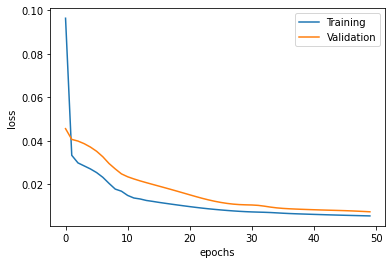

In [23]:
# trianing andd validation loss

plt.plot(hist.history['loss'], label='Training')
plt.plot(hist.history['val_loss'], label='Validation')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc='best')
plt.show()

### Prediction

In [24]:
# predict
y_hat = model.predict(x_test)

In [25]:
# revert the scaling 
y_hat = np.round(y_scaler.inverse_transform(y_hat), 1)

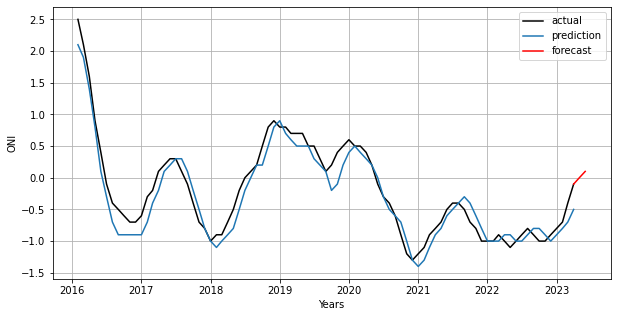

In [26]:
# plot results

# y_test has three columns:
# column 0 = oni values for next month
# column 1 = oni values for the second next month
# column 2 = oni values for the third next month

# plot the oni actual (y_test) and predicted (y_hat) values for the next month
# plot y_hat last row values as the forecast for the next 3 months


# find y_test start row index to get the start of the date range
# add 1 because the values are for the next month
y_start = n_train + n_valid + 1

# oni actual values
y_actual = pd.DataFrame(index = df_reframed.index[y_start:],
                        data = y_scaler.inverse_transform(y_test)[:-1, 0])

# oni predicted values
y_predict = pd.DataFrame(index = df_reframed.index[y_start:],
                         data = y_hat[:-1, 0])

# oni forecast values
y_forecast = pd.DataFrame(index = pd.date_range(start=df_reframed.index[-1], 
                                                periods=n_out, freq= 'MS'),
                          data = y_hat[-1, :])

plt.figure(figsize=(10, 5))
plt.plot(y_actual, label='actual', color='k')
plt.plot(y_predict, label='prediction')
plt.plot(y_forecast, label='forecast', color='r')
plt.xlabel('Years')
plt.ylabel('ONI')
plt.legend()
plt.grid()
plt.show()

### References
- Michelle L'Heureux, "What is the El Niño–Southern Oscillation (ENSO) in a nutshell?" ENSO Blog, 2014, <br> [Online]. Available: https://www.climate.gov/comment/28
- Jason Brownlee , "Time Series Prediction with LSTM Recurrent Neural Networks in Python with Keras," Machine Learning Mastery, 2016, [Online]. Available: https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
- Jason Brownlee , "How to Convert a Time Series to a Supervised Learning Problem in Python," Machine Learning Mastery, 2017, [Online]. Available: https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
- ArcGIS Developers, "Predicting El Niño–Southern Oscillation through correlation and time series analysis/deep learning," ArcGIS API for Python, [Online]. Available: https://developers.arcgis.com/python/samples/predicting-enso/
- Arram Bhaskar , "El-Nina or La-Nina Year Prediction using LSTM," 2019, <br> [Online]. Available: https://www.kaggle.com/code/bhaskar100/el-nina-or-la-nina-year-prediction-using-lstm